<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/ProbabilisticClassificationClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification and clustering: probabilistic modeling approach

Here, we will extend out discussion on estimation theory to classification and clusterin problems.

In [1]:
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

## We will rely heavily on the ```scikit-learn``` library

The ```sklearn``` library is a mature, well-tested library of implementations of many standard machine-learning models and provides a clean API to work with. In addition to being able to fit models and draw predictions for new inputs, ```sklearn``` also provides many useful utilities for handling data, and creating toy datasets for understanding theh pros and cons of various models.  The library is designed to work in conjunction with ```numpy```, ```scipy```, ```matplotlib```, and ```pandas```.

### Start by making a 2D dataset with 2 classes.

In [2]:
from sklearn import datasets
n_classes = 2
n_features = 2
n_samples = 200
n_redundant = 0
n_clusters_per_class = 1
class_sep = 1
X, y = datasets.make_classification(n_classes=n_classes, n_features=n_features,
                                    n_samples=n_samples, n_redundant=n_redundant,
                                    n_clusters_per_class=n_clusters_per_class,
                                    class_sep=class_sep)

### Visualize the dataset

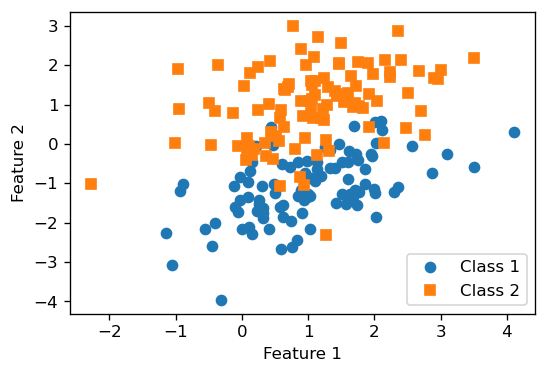

In [3]:
import itertools
marker = itertools.cycle(('o', 's', '*', 'v', '^', 'x')) 
for c in range(n_classes):
    pl.plot(X[y==c, 0], X[y==c, 1], linestyle='', marker=next(marker))
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')
pl.legend(('Class 1', 'Class 2'), loc='best')

## Construct a naive-Bayes classifier and test it by splitting the dataset

For simplicity, we will use the Gaussian naive-Bayes model where the value of each feature is modeled as coming from a 1D normal distribution that is conditioned on class but independent of other features.

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

model = GaussianNB()
model.fit(X_train, y_train)
y_predicted_train = model.predict(X_train)
y_predicted_test = model.predict(X_test)

acc_train = (y_predicted_train == y_train).sum() * 100. / y_train.shape[0]
acc_test = (y_predicted_test == y_test).sum() * 100. / y_test.shape[0]

print(f'Training accuracy = {acc_train:0.1f}%, Test accuracy = {acc_test:0.1f}%')

Training accuracy = 88.1%, Test accuracy = 86.4%


### Visualize results

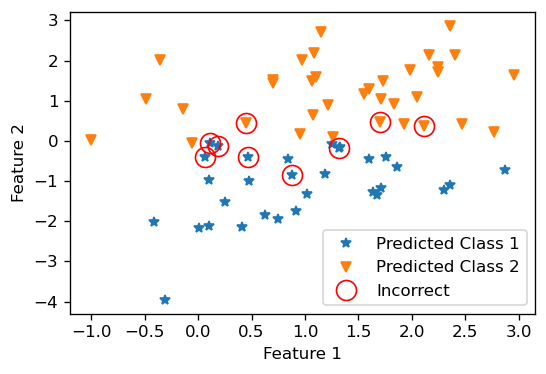

In [5]:
for c in range(n_classes):
    pl.plot(X_test[y_predicted_test==c, 0], X_test[y_predicted_test==c, 1], linestyle='', marker=next(marker))

pl.plot(X_test[y_predicted_test != y_test, 0], X_test[y_predicted_test != y_test, 1], 'or',
        markersize=12, markerfacecolor='none')
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')
pl.legend(('Predicted Class 1', 'Predicted Class 2', 'Incorrect'), loc='best')

## Clustering using mixture modeling

### Create and visualize a 2D dataset

Text(0, 0.5, 'Feature 2')

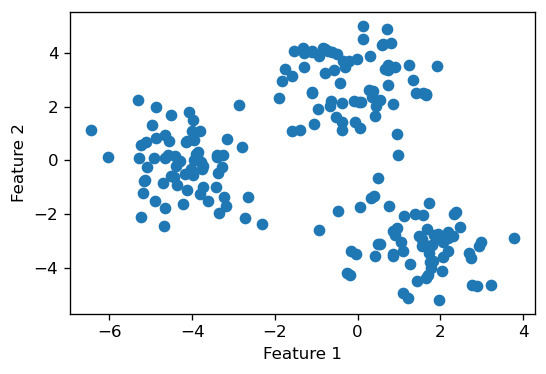

In [6]:
n_clusters = 3
centers = np.asarray([[-4, 0], [0, 3], [1.5, -3]])
X, y = datasets.make_blobs(centers=centers, n_features=n_features,
                           n_samples=n_samples)

pl.plot(X[:, 0], X[:, 1], 'o')
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')

### Use a Gaussian mixture model

The number of clusters is a hyperparameter

Log-likelihood = -3.861477456716295, AIC = 1578.590982686518


Text(0, 0.5, 'Feature 2')

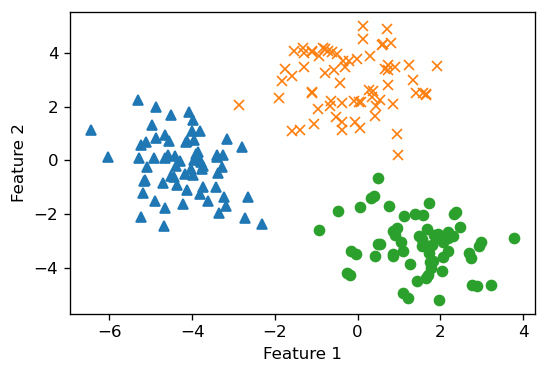

In [7]:
from sklearn import mixture
ncomps = 3
model = mixture.GaussianMixture(n_components=ncomps)
y = model.fit_predict(X)
print(f'Log-likelihood = {model.score(X)}, AIC = {model.aic(X)}')
for k in range(ncomps):
    pl.plot(X[y==k, 0], X[y==k, 1], marker=next(marker), linestyle='')
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')